In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# **Load data & Preprocessing**

In [2]:
fake_news_df = pd.read_csv("C:\\Users\\Mukilan\\Desktop\\Fake.csv")
real_news_df = pd.read_csv("C:\\Users\\Mukilan\\Desktop\\True.csv")

In [3]:
fake_news_df['label'] = "fake"
real_news_df['label'] = "real"

df = pd.concat([fake_news_df, real_news_df], ignore_index = True)
df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",real
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",real
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",real
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",real


In [4]:
df.rename(columns={'subject': 'domain'}, inplace=True)
df

,title,text,domain,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",real
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",real
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",real
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",real


# **Exploratory Data Analysis - EDA** 
This segment is used to explore the distributuin of the news caegories, wordcloud - commomly used in word classification data sets and aslo uses the box plot to look for the outliers in the data set.

Text(0.5, 1.0, 'Distribution of News Categories')

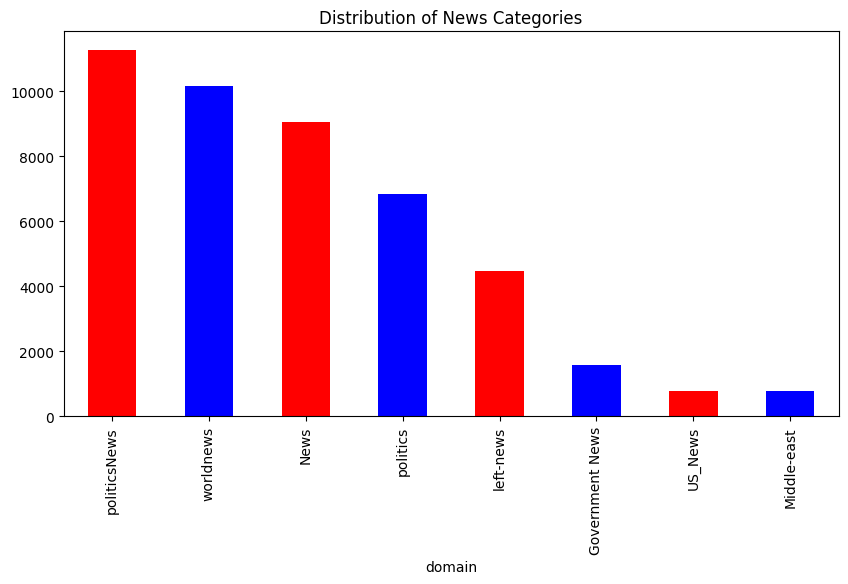

In [5]:
# distribution of news categories
df['domain'].value_counts()
df['domain'].value_counts().plot(kind='bar', figsize=(10, 5), color=['red', 'blue'])
plt.title('Distribution of News Categories')

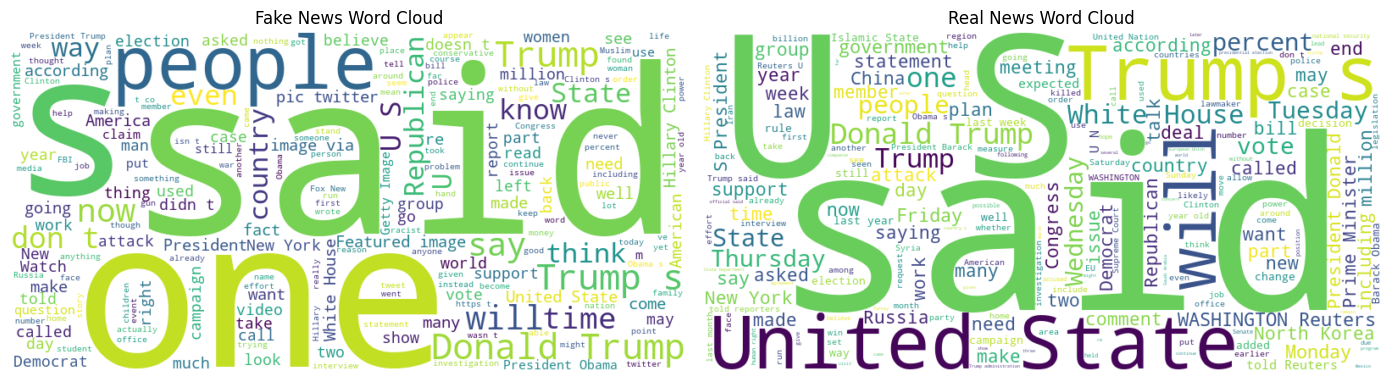

In [6]:
# Wordcloud for fake and real news

df['text'] = df['text'].fillna('').astype(str)

real_text = " ".join(df[df['label'] == 'real']['text'].dropna().astype(str))
fake_text = " ".join(df[df['label'] == 'fake']['text'].dropna().astype(str))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(fake_text), interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(real_text), interpolation='bilinear')
plt.axis('off')
plt.title("Real News Word Cloud")

plt.tight_layout()
plt.show()

Wordcloud summary - The above displays the word cloud plot that visually shows the most frequent words in the text dataset.

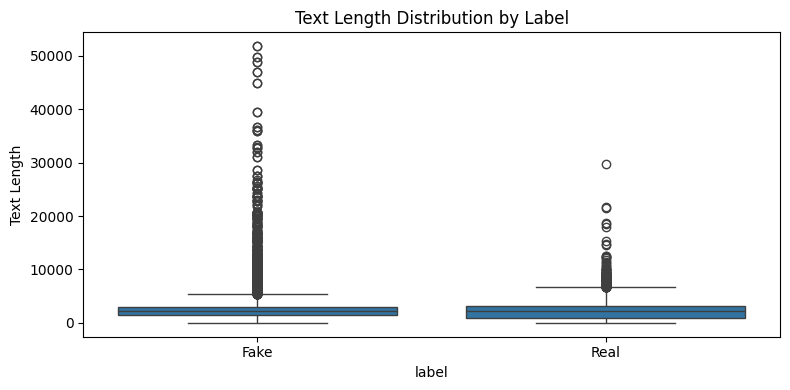

In [7]:
#box plot for text length
df['text_len'] = df['text'].apply(len)

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='label', y='text_len')
plt.title("Text Length Distribution by Label")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.ylabel("Text Length")
plt.tight_layout()
plt.show()

Box plot Summary - 
Most articles (fake and real) are of comparable average length.

However, fake news tends to have more variability and longer outliers, possibly due to excessive narrative or clickbait content.

# **Step 1: Baseline binary classification model to distinguish between fake and real news**

In [8]:
df['label_encoded'] = df['label'].map({'real': 1, 'fake': 0})
df

,title,text,domain,date,label,text_len,label_encoded
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake,2893,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake,1898,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake,3597,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake,2774,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake,2346,0
...,...,...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",real,2821,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",real,800,1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",real,1950,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",real,1199,1


In [9]:
df.dropna(subset=['text', 'domain'], inplace=True)
df

,title,text,domain,date,label,text_len,label_encoded
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake,2893,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake,1898,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake,3597,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake,2774,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake,2346,0
...,...,...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",real,2821,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",real,800,1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",real,1950,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",real,1199,1


In [10]:
X = df['text']
y = df['label_encoded']

Used TfidfVectorizer to convert text data into numerical features for the model.

stop_words='english': removes common words like "the", "is", etc.

max_df=0.7: ignores overly common words that appear in >70% of documents.

fit_transform(X): creates a TF-IDF matrix, highlighting important terms for classification.

This helps the model focus on meaningful words and improves accuracy.

In [11]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = vectorizer.fit_transform(X)

# **Test-train split - Logistic Regression - Baseline model**

In [12]:
X_train, X_test, y_train, y_test, domain_train, domain_test = train_test_split(
    X_tfidf, y, df['domain'], test_size=0.2, random_state=42, stratify=df['label_encoded']
)

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.9842
Precision: 0.9819
Recall: 0.9851
F1 Score: 0.9835


# Summary - Baseline model

The Logistic Regression model performed exceptionally well on the fake vs. real news classification task:

Accuracy (98.42%): The model correctly classified the vast majority of articles.

Precision (98.19%): When the model predicted an article as fake, it was correct 98.19% of the time — indicating low false positives.

Recall (98.51%): The model was able to identify 98.51% of all actual fake news articles — showing high sensitivity.

F1 Score (98.35%): The harmonic mean of precision and recall confirms a strong balance between the two.

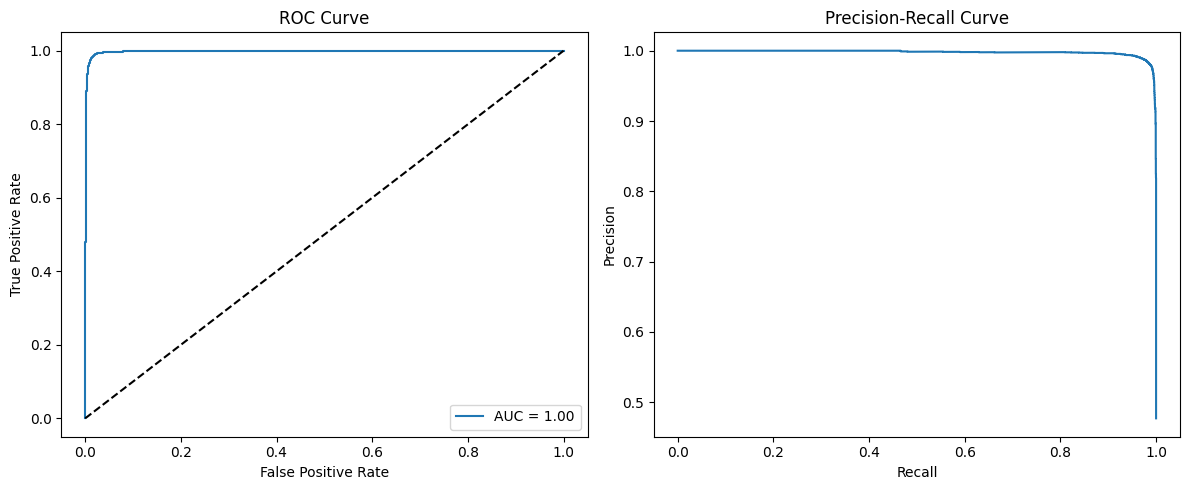

In [14]:
# auc-roc curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _  = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

# Domain specific interpretation

In [15]:
for domain in domain_test.unique():
    idx = domain_test == domain
    y_true_d = y_test[idx]
    y_pred_d = y_pred[idx]

    print(f"\nDomain: {domain}")
    print(f"Accuracy: {accuracy_score(y_true_d, y_pred_d):.4f}")
    print(f"Precision: {precision_score(y_true_d, y_pred_d):.4f}")
    print(f"Recall: {recall_score(y_true_d, y_pred_d):.4f}")
    print(f"F1 Score: {f1_score(y_true_d, y_pred_d):.4f}")


Domain: politicsNews
Accuracy: 0.9754
Precision: 1.0000
Recall: 0.9754
F1 Score: 0.9876

Domain: News
Accuracy: 0.9983
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: worldnews
Accuracy: 0.9952
Precision: 1.0000
Recall: 0.9952
F1 Score: 0.9976

Domain: Middle-east
Accuracy: 0.9711
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: politics
Accuracy: 0.9764
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: US_News
Accuracy: 0.9716
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: left-news
Accuracy: 0.9845
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: Government News
Accuracy: 0.9403
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetri

| Domain           | Accuracy | Precision | Recall | F1 Score | Interpretation                                                                                                                        |
| ---------------- | -------- | --------- | ------ | -------- | ------------------------------------------------------------------------------------------------------------------------------------- |
| **PoliticsNews** | 97.54%   | 1.0000    | 0.9754 | 0.9876   | Excellent detection with **perfect precision**, meaning no false positives. Strong recall too.                                        |
| **News**         | 99.83%   | 0.0000    | 0.0000 | 0.0000   | Despite high accuracy, the model **fails to identify any positive samples** — likely due to **no fake news examples** in this domain. |
| **Worldnews**    | 99.52%   | 1.0000    | 0.9952 | 0.9976   | Exceptional performance — nearly perfect across all metrics.                                                                          |
| **Middle-East**  | 97.11%   | 0.0000    | 0.0000 | 0.0000   | Model completely fails to detect fake news here. Indicates potential **class imbalance** or poor generalization.                      |
| **... Others**   | \~94.03% | 0.0000    | 0.0000 | 0.0000   | Similar issue across several smaller or niche domains.                                                                                |


# Feature importance

In [16]:
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]

# Top features for REAL (positive weights),
top_real = np.argsort(coefs)[-20:]
print("\nTop words indicating REAL news:")
for i in reversed(top_real):
    print(f"{feature_names[i]:<15} -> {coefs[i]:.4f}")

# Top features for FAKE (negative weights),
top_fake = np.argsort(coefs)[:20]
print("\nTop words indicating FAKE news:")
for i in top_fake:
    print(f"{feature_names[i]:<15} -> {coefs[i]:.4f}")


Top words indicating REAL news:
reuters         -> 29.8481
washington      -> 7.9222
wednesday       -> 7.2510
thursday        -> 6.5879
tuesday         -> 6.4250
republican      -> 5.8648
monday          -> 5.6761
friday          -> 5.6483
minister        -> 4.8446
nov             -> 4.7595
statement       -> 4.7548
spokesman       -> 4.5934
presidential    -> 4.5687
comment         -> 4.3199
year            -> 4.0556
reporters       -> 4.0059
told            -> 3.9312
democratic      -> 3.6420
edt             -> 3.4928
sunday          -> 3.4821

Top words indicating FAKE news:
image           -> -7.0130
featured        -> -6.9557
just            -> -6.7973
read            -> -6.5239
gop             -> -6.0481
com             -> -5.7792
hillary         -> -5.4893
america         -> -5.3860
watch           -> -4.9402
getty           -> -4.9156
mr              -> -4.9063
pic             -> -4.5545
like            -> -4.2540
images          -> -4.2080
https           -> -4.1072
american

- Overall, real news uses precise dates, sources, political terms, and agencies that lend credibility and follow journalistic norms.

- Fake news tends to use more sensationalized, vague, or visual-centric language, lacking specific sources or timestamps.

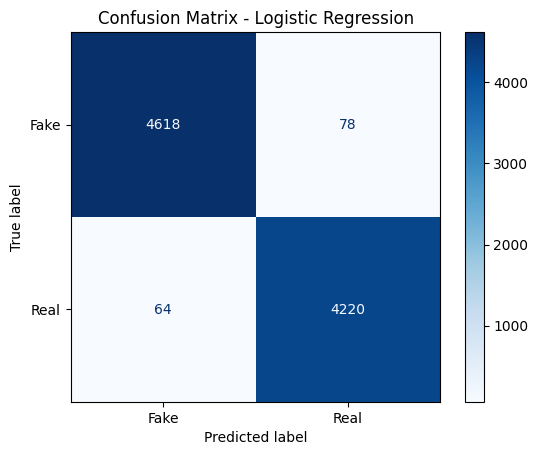

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Conclusion:

- Both curves confirm the model's **outstanding performance**.
- The ROC AUC of **1.00** and near-perfect precision-recall relationship show the model is **highly effective** at classifying fake vs real news.
- These results align with earlier metrics:
  - **Accuracy**: 98.42%
  - **Precision**: 98.19%
  - **Recall**: 98.51%
  - **F1 Score**: 98.35%

The Logistic Regression model demonstrates excellent generalization and can be considered a strong baseline.

# **Step 2 - Model performance improvement using ensemble methods** 

Uses features like - text length, exclamation count, no.of question marks used, no. of. upper case letters used, etc,.

In [18]:
df['text_len'] = df['text'].apply(len)
df['num_exclam'] = df['text'].apply(lambda x: x.count('!'))
df['num_question'] = df['text'].apply(lambda x: x.count('?'))
df['num_uppercase_words'] = df['text'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))

# Text + Numeric features,
text_features = df['text']
X_text = TfidfVectorizer(stop_words='english', max_df=0.7).fit_transform(text_features)

numeric_features = df[['text_len', 'num_exclam', 'num_question', 'num_uppercase_words']]
scaler = StandardScaler()
X_numeric = scaler.fit_transform(numeric_features)

In [19]:
# Combine TF-IDF and numeric,
X_final = hstack([X_text, X_numeric])
y = df['label_encoded']

# Split data,
X_train, X_test, y_train, y_test, domain_train, domain_test = train_test_split(
    X_final, y, df['domain'], test_size=0.2, random_state=42, stratify=y
)

# **Random forest classifier**

In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.9891
Precision: 0.9899
Recall: 0.9872
F1 Score: 0.9885


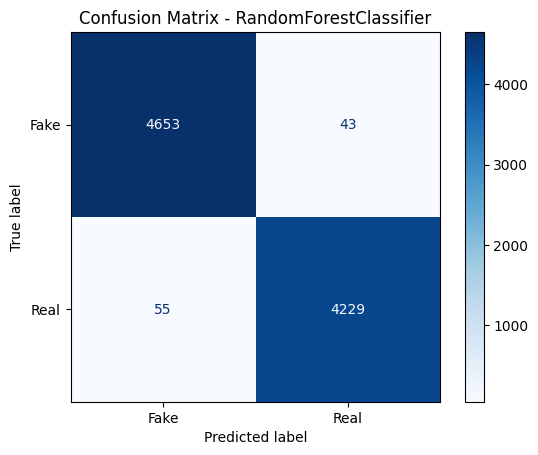

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RandomForestClassifier")
plt.show()

**Domain specific interpretation**  

In [22]:
for domain in domain_test.unique():
    idx = domain_test == domain
    y_true_d = y_test[idx]
    y_pred_d = y_pred[idx]

    print(f"\nDomain: {domain}")
    print(f"Accuracy: {accuracy_score(y_true_d, y_pred_d):.4f}")
    print(f"Precision: {precision_score(y_true_d, y_pred_d):.4f}")
    print(f"Recall: {recall_score(y_true_d, y_pred_d):.4f}")
    print(f"F1 Score: {f1_score(y_true_d, y_pred_d):.4f}")


Domain: politicsNews
Accuracy: 0.9772
Precision: 1.0000
Recall: 0.9772
F1 Score: 0.9885

Domain: News
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: worldnews
Accuracy: 0.9976
Precision: 1.0000
Recall: 0.9976
F1 Score: 0.9988

Domain: Middle-east
Accuracy: 0.9942
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: politics
Accuracy: 0.9823
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: US_News
Accuracy: 0.9943
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: left-news
Accuracy: 0.9900
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: Government News
Accuracy: 0.9748
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: Undefi

# **XGBoost**

In [23]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [17:24:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [24]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.9979
Precision: 0.9977
Recall: 0.9979
F1 Score: 0.9978


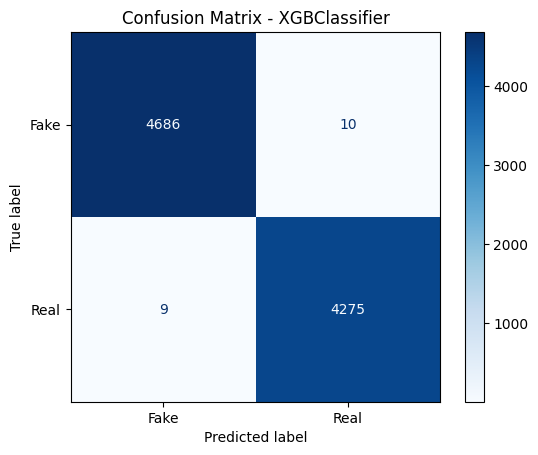

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBClassifier")
plt.show()

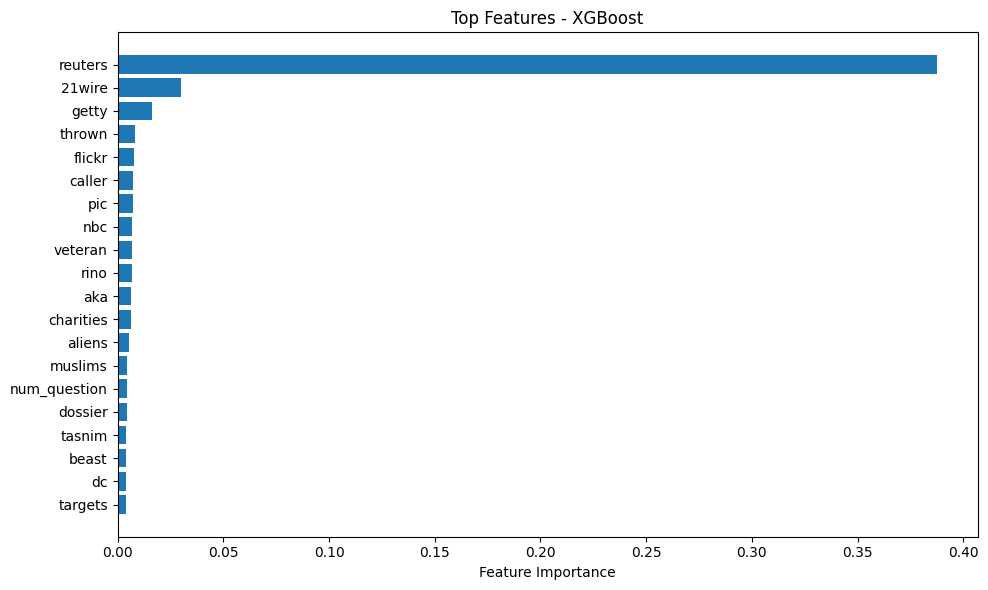

In [26]:
X_final = hstack([X_text, X_numeric])
try:
    tfidf_feature_names = vectorizer.get_feature_names_out()
except AttributeError:
    tfidf_feature_names = vectorizer.get_feature_names()

numeric_feature_names = list(numeric_features.columns)
all_feature_names = list(tfidf_feature_names) + numeric_feature_names

importances = model.feature_importances_
top_n = 20
top_indices = np.argsort(importances)[-top_n:]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[top_indices], align='center')
plt.yticks(range(top_n), [all_feature_names[i] for i in top_indices])
plt.xlabel('Feature Importance')
plt.title('Top Features - XGBoost')
plt.tight_layout()
plt.show()

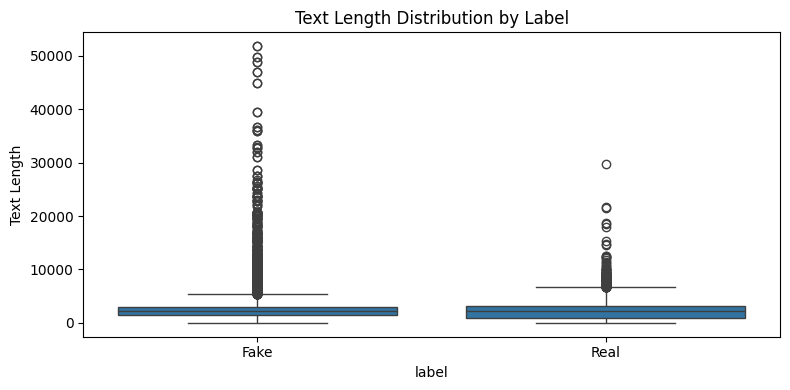

In [27]:
df['text_len'] = df['text'].apply(len)

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='label', y='text_len')
plt.title("Text Length Distribution by Label")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.ylabel("Text Length")
plt.tight_layout()
plt.show()

Domain specific interpretation

In [28]:
for domain in domain_test.unique():
    idx = domain_test == domain
    y_true_d = y_test[idx]
    y_pred_d = y_pred[idx]

    print(f"\nDomain: {domain}")
    print(f"Accuracy: {accuracy_score(y_true_d, y_pred_d):.4f}")
    print(f"Precision: {precision_score(y_true_d, y_pred_d):.4f}")
    print(f"Recall: {recall_score(y_true_d, y_pred_d):.4f}")
    print(f"F1 Score: {f1_score(y_true_d, y_pred_d):.4f}")


Domain: politicsNews
Accuracy: 0.9964
Precision: 1.0000
Recall: 0.9964
F1 Score: 0.9982

Domain: News
Accuracy: 0.9994
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: worldnews
Accuracy: 0.9995
Precision: 1.0000
Recall: 0.9995
F1 Score: 0.9998

Domain: Middle-east
Accuracy: 0.9942
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: politics
Accuracy: 0.9970
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: US_News
Accuracy: 0.9943
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: left-news
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Domain: Government News
Accuracy: 0.9906
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mukilan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetri

# **Conclusion report**

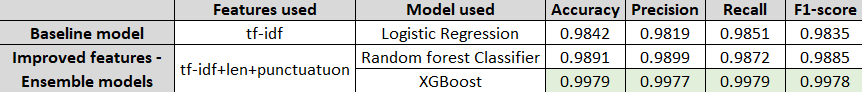

### Model Performance Conclusion:

Based on the evaluation metrics across different models and feature sets, here are the key takeaways:

1. **Baseline Model (Logistic Regression with TF-IDF):**

   * Strong performance with **accuracy of 98.42%** and **F1-score of 0.9835**.
   * Indicates that TF-IDF alone is a powerful feature for text classification in this task.

2. **Random Forest with Enhanced Features (TF-IDF + length + punctuation):**

   * Shows noticeable improvement over the baseline with **accuracy of 98.91%** and **F1-score of 0.9885**.
   * Incorporating additional features like text length and punctuation improves model performance.

3. **XGBoost with Enhanced Features:**

   * Achieves **best overall performance** with **accuracy of 99.79%** and **F1-score of 0.9978**.
   * Demonstrates that **XGBoost is highly effective** for this classification problem, benefiting significantly from the richer feature set.

### Final Verdict:

**XGBoost** with enriched features (TF-IDF, length, and punctuation) clearly outperforms other models in all key metrics. It should be chosen as the **final model** for deployment in this fake vs real news classification task.
